# Work to undnerstand how to use the kappa distribution in pymc3

In [44]:
import itertools

import matplotlib.pyplot as plt
import matplotlib as mpl
from pymc3 import Model, Normal, Slice
from pymc3 import sample
from pymc3 import traceplot
from pymc3.distributions import Interpolated
from theano import as_op
import theano.tensor as tt
import numpy as np
from scipy import stats
import tqdm

%matplotlib inline

%load_ext version_information

%version_information pymc3, scipy



The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.6.2 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
IPython 6.1.0
OS Darwin 15.6.0 x86_64 i386 64bit
pymc3 3.1
scipy 0.19.1
Mon Sep 18 12:13:55 2017 MDT

In [3]:
stats.kappa3?

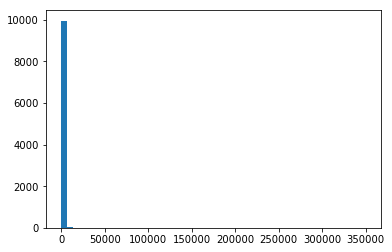

In [14]:
k3_rvs = stats.kappa3.rvs(a=1, loc=90, scale=45, size=10000)
plt.hist(k3_rvs, 50);


4.621500393020947 0.023720538535741298 17.440372233406986 431.65646930084574


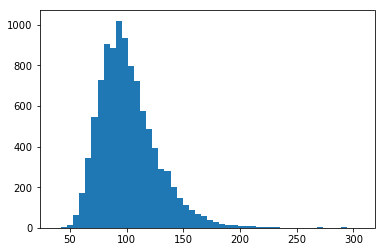

In [111]:
# stats.kappa4?
h=100
k=0
k4_pdf = stats.kappa4.rvs(h=k, k=k, loc=90, scale=20, size=10000)
plt.hist(k4_pdf, 50);
mean, var, skew, kurt = stats.kappa4.stats(h, k, moments='mvsk')
print(mean, var, skew, kurt)

In [24]:
import scipy.optimize

In [92]:
def moments(x):
    h, k = x
    mean, var, skew, kurt = stats.kappa4.stats(h, k, moments='mvsk')
    return skew

minme = lambda x: np.abs(moments(x))

x0 = [.2, 4]

minme(x0)


7.5529025101903082

In [97]:
# optimization seems slow, lets try a brute force to get a feel
N=7
h = np.linspace(0, 5, N)
k = np.linspace(0, 5, N)

H, K = np.meshgrid(h, k)

ans = np.zeros((N,N), dtype=float)

In [98]:


for i, j in tqdm.tqdm(itertools.product(range(N), range(N)), total=N*N):
    ans[i,j] = minme((H[i,j], K[i,j]))



 86%|████████▌ | 42/49 [00:52<00:02,  2.66it/s]/Users/balarsen/miniconda3/envs/python3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)
100%|██████████| 49/49 [00:58<00:00,  2.84it/s]


(1, 1)
0.00946777071186
0.833333333333 0.833333333333


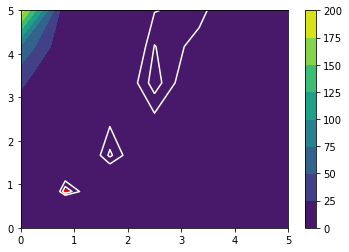

In [100]:
plt.contourf(H,K,ans)
plt.colorbar()
plt.contour(H,K,ans, levels=[0,.1,.2], colors='w')

print(np.unravel_index(np.argmin(ans), ans.shape))
print(ans.min())
min = np.unravel_index(np.argmin(ans), ans.shape)
plt.scatter(H[min], K[min], marker='o', c='r')
print(H[min], K[min])

In [91]:
niter = 0
def callbackF(x):
    global niter
    print("{} : {}, {}".format(niter, x[0], x[1]))
    niter += 1

  
scipy.optimize.minimize(minme, x0, method='TNC', callback=callbackF, bounds=[[0,1], [0,1]])

KeyboardInterrupt: 

# Try VonMises

In [112]:
kappa = 3.99390425811
mean, var, skew, kurt = stats.vonmises.stats(kappa, moments='mvsk')
print(mean, var, skew, kurt)

4.995631231732412e-17 0.2988042418167408 4.572598569626176e-16 0.6905715325848036


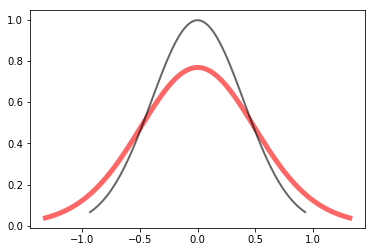

In [122]:
x = np.linspace(stats.vonmises.ppf(0.01, kappa), stats.vonmises.ppf(0.99, kappa), 100)

plt.plot(x, stats.vonmises.pdf(x, kappa), 'r-', lw=5, alpha=0.6, label='vonmises pdf')

x = np.linspace(stats.norm.ppf(0.01, loc=0, scale=.4, ), stats.norm.ppf(0.99, loc=0, scale=.4, ), 100)

plt.plot(x, stats.norm.pdf(x, loc=0, scale=.4), 'k', lw=2, alpha=0.6, label='normal pdf')

